<a href="https://colab.research.google.com/github/NikhilAsogekar3/Deep-generative-models/blob/Nikhil-Asogekar/AE_and_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        overall_loss = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            overall_loss += loss.item()
            loss.backward()
            opt.step()
        print(f"Epoch: {epoch+1},   Avg loss: {(overall_loss/(len(data))):>8f} \n")
    return autoencoder

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

data = DataLoader(train_data, batch_size = 128, shuffle = True)
test_data = DataLoader(test_data, batch_size = 128, shuffle = True)

In [ ]:
autoencoder = train(autoencoder, data)

Epoch: 1,   Avg loss: 5640.021976 

Epoch: 2,   Avg loss: 4794.181477 

Epoch: 3,   Avg loss: 4596.755959 

Epoch: 4,   Avg loss: 4492.383765 

Epoch: 5,   Avg loss: 4420.933674 

Epoch: 6,   Avg loss: 4365.895159 

Epoch: 7,   Avg loss: 4319.019128 

Epoch: 8,   Avg loss: 4280.917492 

Epoch: 9,   Avg loss: 4246.240163 

Epoch: 10,   Avg loss: 4216.299550 

Epoch: 11,   Avg loss: 4189.647015 

Epoch: 12,   Avg loss: 4165.608556 

Epoch: 13,   Avg loss: 4143.623735 

Epoch: 14,   Avg loss: 4124.452791 

Epoch: 15,   Avg loss: 4105.831591 

Epoch: 16,   Avg loss: 4087.219311 

Epoch: 17,   Avg loss: 4070.846006 

Epoch: 18,   Avg loss: 4057.484708 

Epoch: 19,   Avg loss: 4044.273008 

Epoch: 20,   Avg loss: 4027.653177 



In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

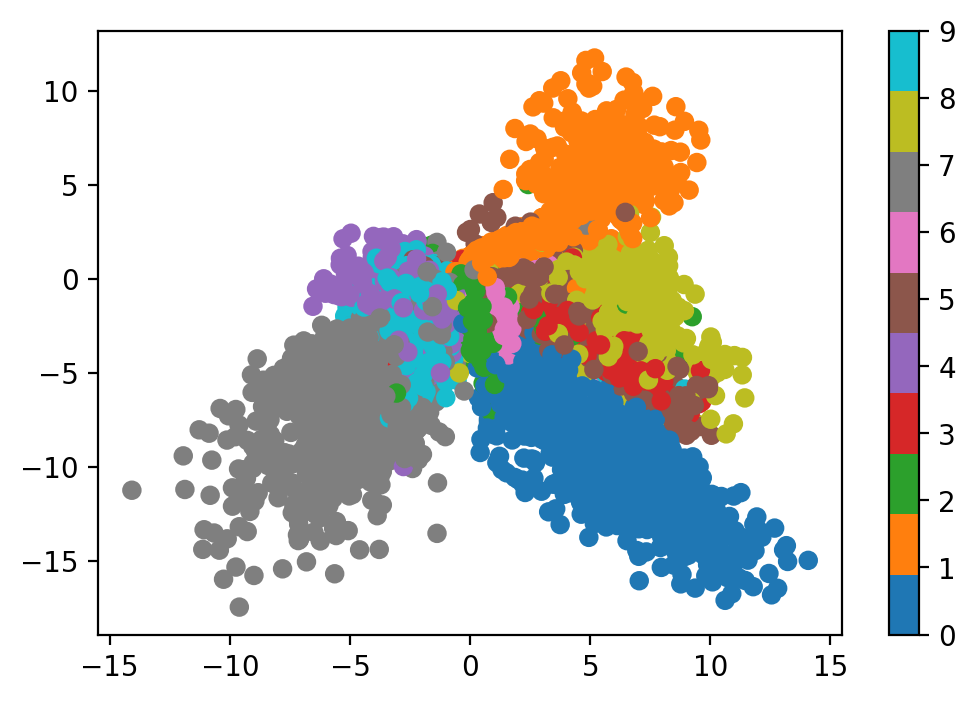

In [ ]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

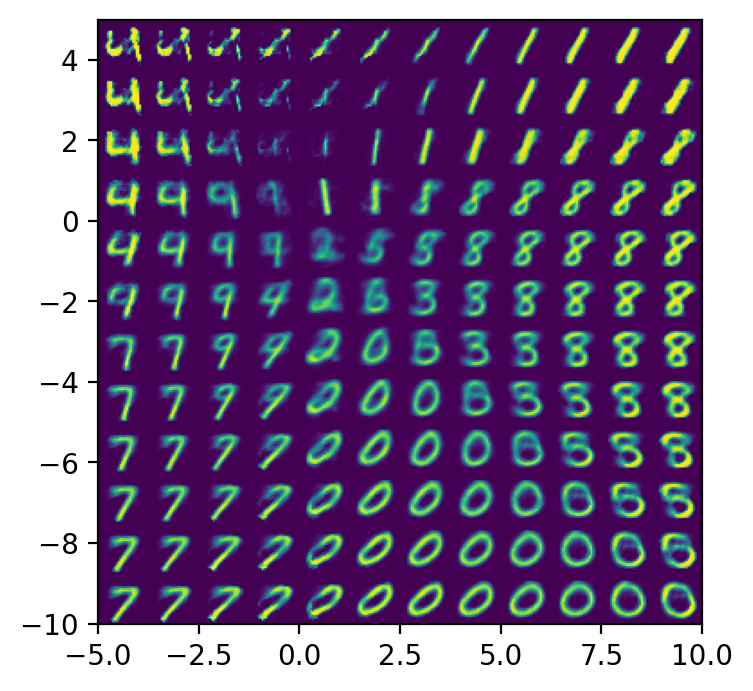

In [ ]:
plot_reconstructed(autoencoder)

In [ ]:
latent_dims = 2

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
avg_loss = []
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        overall_loss = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            overall_loss += loss.item()
            loss.backward()
            opt.step()
        print(f"Epoch: {epoch+1},   Avg loss: {(overall_loss/(len(data))):>8f} \n")
        avg_loss.append((overall_loss/(len(data))))
    return autoencoder, avg_loss

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae, avg_loss = train(vae, data)

Epoch: 1,   Avg loss: 6333.055377 

Epoch: 2,   Avg loss: 5560.407167 

Epoch: 3,   Avg loss: 5435.416036 

Epoch: 4,   Avg loss: 5348.033666 

Epoch: 5,   Avg loss: 5269.629122 

Epoch: 6,   Avg loss: 5209.547120 

Epoch: 7,   Avg loss: 5160.854283 

Epoch: 8,   Avg loss: 5121.524504 

Epoch: 9,   Avg loss: 5090.478070 

Epoch: 10,   Avg loss: 5061.700551 

Epoch: 11,   Avg loss: 5034.953512 

Epoch: 12,   Avg loss: 5014.582287 

Epoch: 13,   Avg loss: 4993.663756 

Epoch: 14,   Avg loss: 4981.498397 

Epoch: 15,   Avg loss: 4963.213108 

Epoch: 16,   Avg loss: 4950.038276 

Epoch: 17,   Avg loss: 4937.805853 

Epoch: 18,   Avg loss: 4922.187857 

Epoch: 19,   Avg loss: 4910.604530 

Epoch: 20,   Avg loss: 4897.298000 



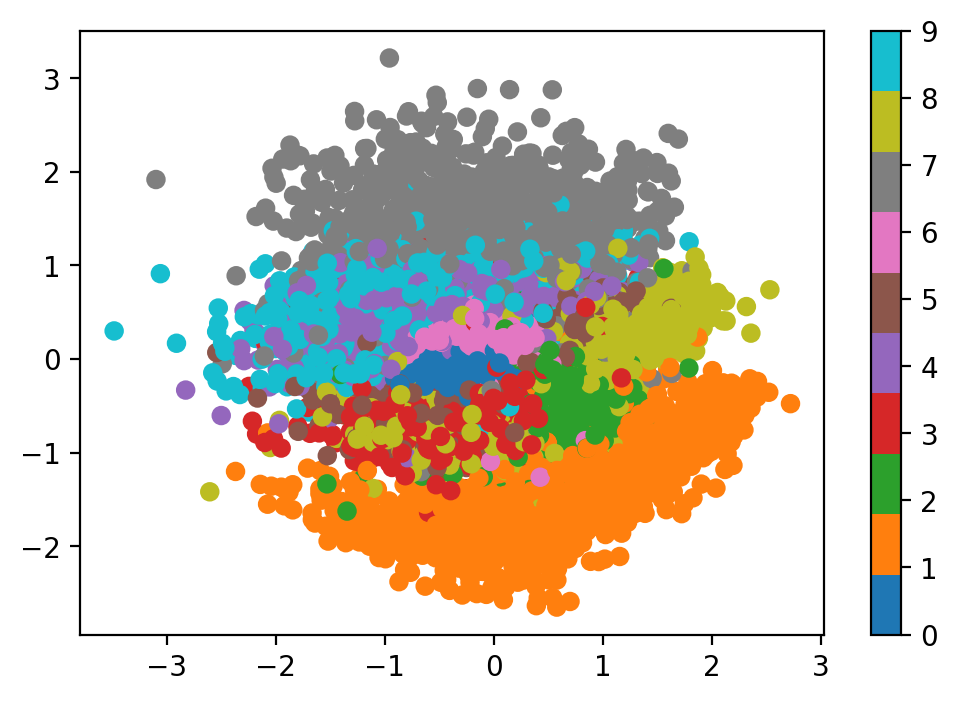

In [ ]:
plot_latent(vae, data)

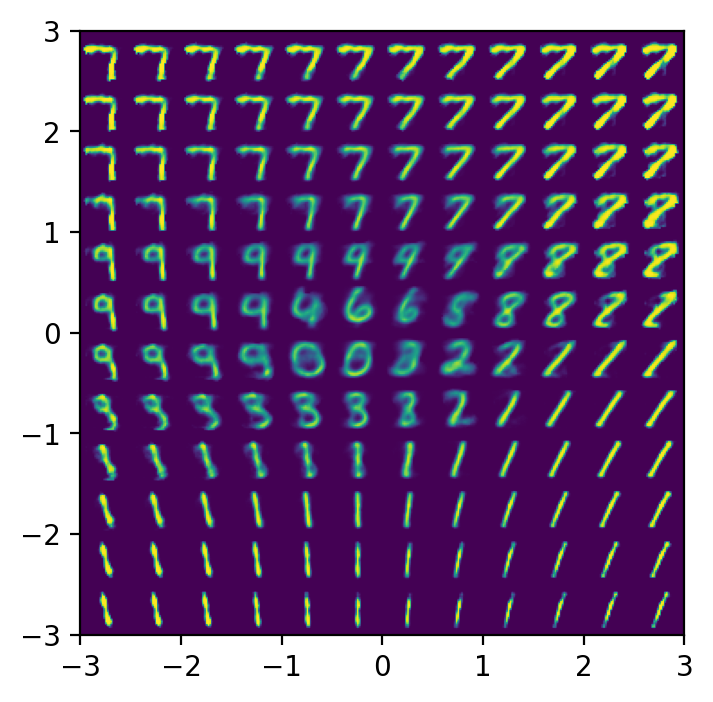

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

Text(0, 0.5, 'Avg loss')

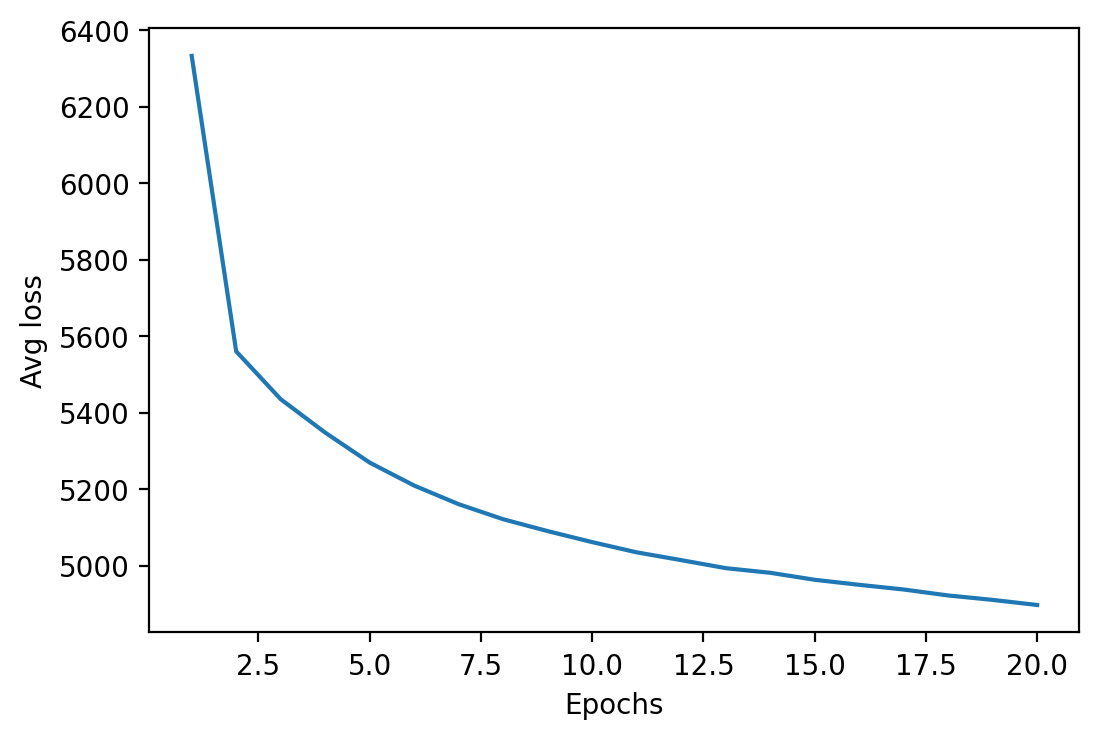

In [ ]:
t = range(1, 21)
plt.plot(t, avg_loss)
plt.xlabel("Epochs")
plt.ylabel("Avg loss")